<a href="https://colab.research.google.com/github/Illuminati014/Pest-detection/blob/main/pest_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os
import re
import random

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Print the result
if torch.cuda.is_available():
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")


# Hyperparameters
num_epochs = 50
batch_size = 32
learning_rate = 0.001

# Dataset Directory (Replace with your Google Drive folder path)
data_dir = "/content/drive/My Drive/Data-set/Pest_detection"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using GPU: Tesla T4


In [ ]:
# Function to rename subfolders dynamically
def rename_folders(root_dir):
    for split in ["train", "test"]:
        split_dir = os.path.join(root_dir, split)
        if os.path.exists(split_dir):
            for folder in os.listdir(split_dir):
                old_path = os.path.join(split_dir, folder)
                new_folder_name = re.sub(r"(_test|_train)$", "", folder)  # Remove "_test" and "_train"
                new_path = os.path.join(split_dir, new_folder_name)
                if old_path != new_path:
                    os.rename(old_path, new_path)
                    print(f"Renamed: {old_path} -> {new_path}")

# Run the renaming function
rename_folders(data_dir)

# Data Transformations
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

# Load Dataset
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ["train", "test"]
}

# Downsampling: Match all classes to the smallest class size
def downsample_dataset(dataset):
    # Count samples per class
    class_counts = {i: 0 for i in range(len(dataset.classes))}
    for _, label in dataset.samples:
        class_counts[label] += 1

    min_samples = min(class_counts.values())  # Find smallest class count

    # Select random indices to keep for each class
    selected_indices = []
    class_sample_indices = {i: [] for i in range(len(dataset.classes))}

    for idx, (path, label) in enumerate(dataset.samples):
        class_sample_indices[label].append(idx)

    for label, indices in class_sample_indices.items():
        selected_indices.extend(random.sample(indices, min_samples))  # Randomly pick min_samples for each class

    return Subset(dataset, selected_indices)

# Apply downsampling to balance train and test sets
image_datasets["train"] = downsample_dataset(image_datasets["train"])
image_datasets["test"] = downsample_dataset(image_datasets["test"])

# Data Loaders
dataloaders = {
    "train": DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True),
    "test": DataLoader(image_datasets["test"], batch_size=batch_size, shuffle=True)
}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "test"]}

# Load Pretrained ResNet-50 Model
model = models.resnet50(pretrained=True)
num_classes = len(image_datasets["train"].dataset.classes)  # Number of pest classes
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Replace final layer
model = model.to(device)

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
def train_model(model, criterion, optimizer, start_epoch, num_epochs):
    for epoch in range(start_epoch, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        model.train()
        running_loss = 0.0
        running_corrects = 0
        for inputs, labels in dataloaders["train"]:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / dataset_sizes['train']
        train_acc = running_corrects.double() / dataset_sizes['train']
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")

        # Evaluate the model after 50 and 75 epochs
        if epoch == 50 or epoch == 75:
            print(f"Testing model after {epoch} epochs:")
            test_model(model)

        # Save the model at those epochs
        if epoch == 50 or epoch == 75:
            torch.save(model.state_dict(), f"/content/drive/My Drive/resnet50_pest_detection_{epoch}_epochs.pth")
            print(f"Model saved for {epoch} epochs")


In [ ]:
def test_model(model):
    model.eval()  # Set the model to evaluation mode
    all_preds, all_labels = [], []  # Lists to store all predictions and true labels
    sample_images, sample_labels, sample_preds = [], [], []  # Lists for storing samples for visualization

    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, labels in dataloaders["test"]:  # Loop through test data
            inputs, labels = inputs.to(device), labels.to(device)  # Send data to the device (GPU/CPU)
            outputs = model(inputs)  # Get the model's predictions
            _, preds = torch.max(outputs, 1)  # Get the predicted class index
            all_preds.extend(preds.cpu().numpy())  # Store predictions on CPU
            all_labels.extend(labels.cpu().numpy())  # Store true labels on CPU

            # Store sample images, labels, and predictions for visualization (only for the first 12 samples)
            if len(sample_images) < 12:
                sample_images.extend(inputs.cpu()[:12 - len(sample_images)])
                sample_labels.extend(labels.cpu().numpy()[:12 - len(sample_labels)])
                sample_preds.extend(preds.cpu().numpy()[:12 - len(sample_preds)])

    # Classification report for precision, recall, F1 score, etc.
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=image_datasets["train"].dataset.classes))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Visualize confusion matrix
    plt.show()


    for i in range(len(sample_images)):
         print(f"True: {sample_labels[i]}, Pred: {sample_preds[i]}")
         plt.imshow(sample_images[i].permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
         plt.show()


Epoch 1/75
Train Loss: 1.6762 Acc: 0.3620
Epoch 2/75
Train Loss: 1.3595 Acc: 0.4994
Epoch 3/75
Train Loss: 1.2750 Acc: 0.5281
Epoch 4/75
Train Loss: 1.0650 Acc: 0.6105
Epoch 5/75
Train Loss: 0.9869 Acc: 0.6477
Epoch 6/75
Train Loss: 0.8211 Acc: 0.7192
Epoch 7/75
Train Loss: 0.6931 Acc: 0.7473
Epoch 8/75
Train Loss: 0.6542 Acc: 0.7625
Epoch 9/75
Train Loss: 0.5470 Acc: 0.8211
Epoch 10/75
Train Loss: 0.5355 Acc: 0.8144
Epoch 11/75
Train Loss: 0.4413 Acc: 0.8413
Epoch 12/75
Train Loss: 0.4511 Acc: 0.8504
Epoch 13/75
Train Loss: 0.4722 Acc: 0.8443
Epoch 14/75
Train Loss: 0.4815 Acc: 0.8413
Epoch 15/75
Train Loss: 0.3668 Acc: 0.8675
Epoch 16/75
Train Loss: 0.2528 Acc: 0.9078
Epoch 17/75
Train Loss: 0.2430 Acc: 0.9200
Epoch 18/75
Train Loss: 0.3182 Acc: 0.8932
Epoch 19/75
Train Loss: 0.2396 Acc: 0.9231
Epoch 20/75
Train Loss: 0.2120 Acc: 0.9274
Epoch 21/75
Train Loss: 0.1765 Acc: 0.9347
Epoch 22/75
Train Loss: 0.1341 Acc: 0.9603
Epoch 23/75
Train Loss: 0.4137 Acc: 0.8724
Epoch 24/75
Train Lo

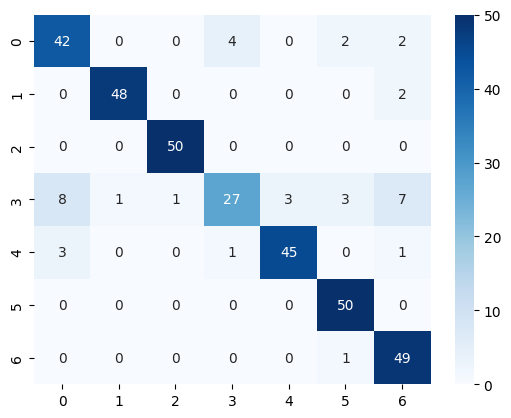

True: 2, Pred: 2


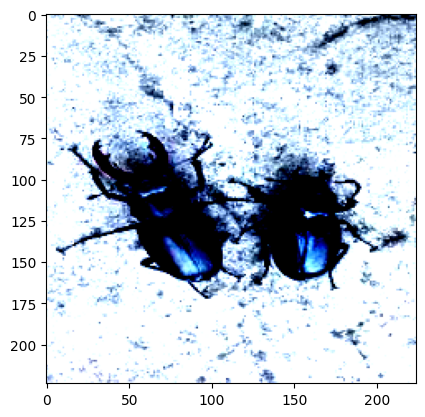

True: 1, Pred: 1


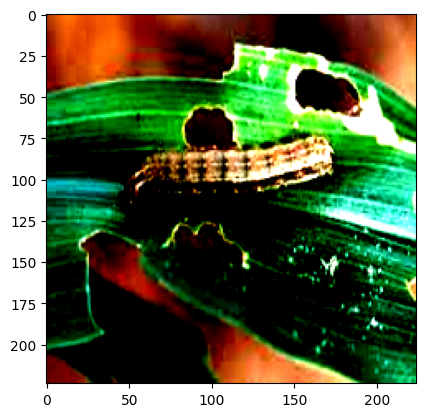

True: 6, Pred: 6


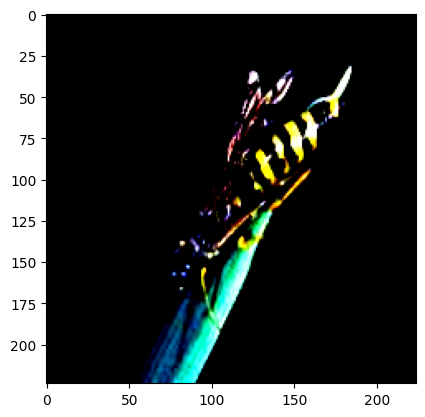

True: 3, Pred: 3


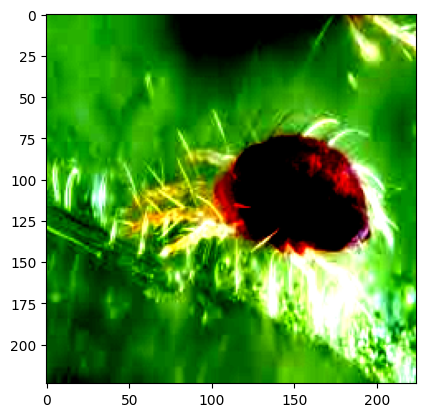

True: 4, Pred: 4


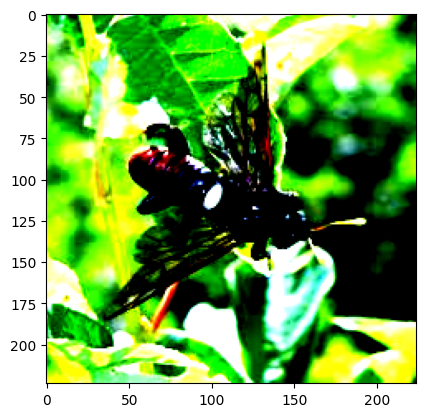

True: 0, Pred: 0


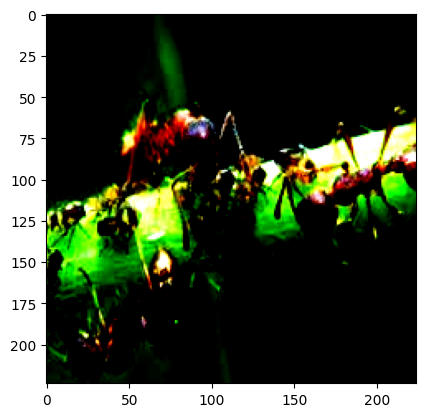

True: 5, Pred: 5


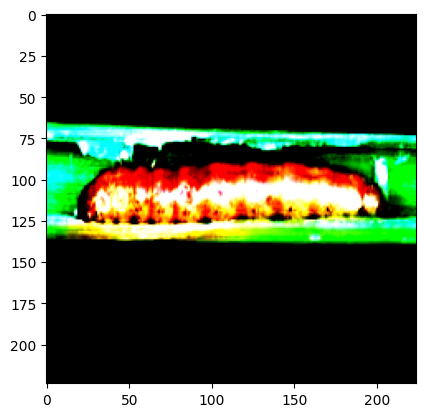

True: 2, Pred: 2


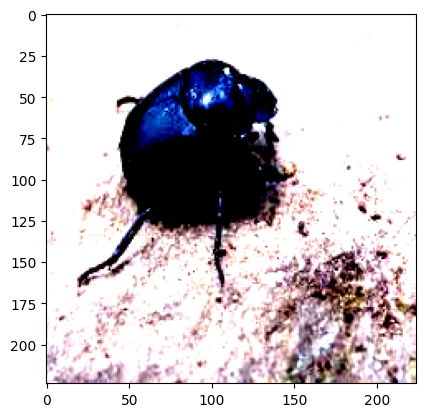

True: 3, Pred: 3


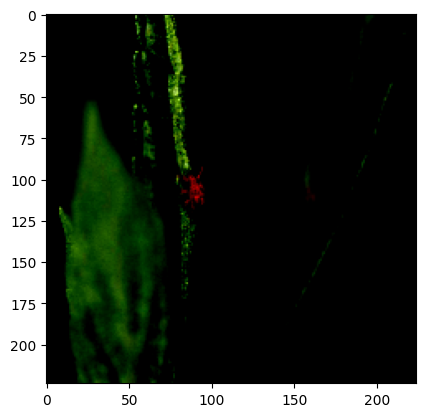

True: 6, Pred: 6


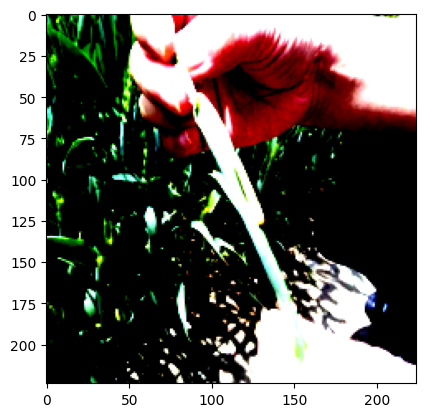

True: 5, Pred: 5


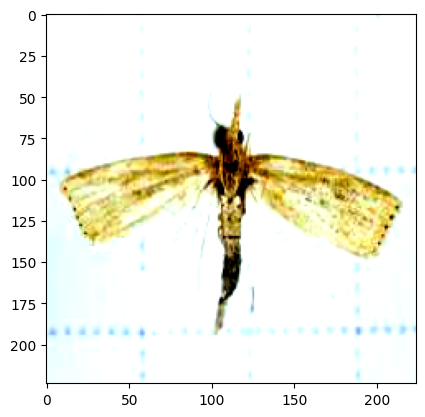

True: 3, Pred: 6


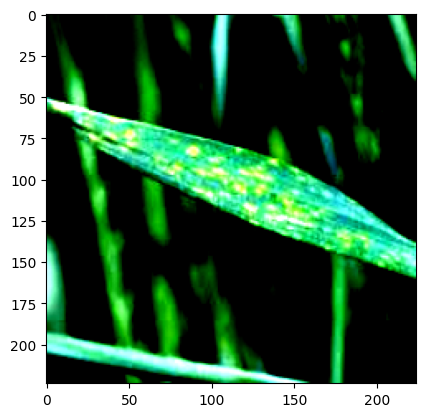

Model saved for 50 epochs
Epoch 51/75
Train Loss: 0.1998 Acc: 0.9396
Epoch 52/75
Train Loss: 0.2552 Acc: 0.9170
Epoch 53/75
Train Loss: 0.1729 Acc: 0.9451
Epoch 54/75
Train Loss: 0.1796 Acc: 0.9438
Epoch 55/75
Train Loss: 0.1045 Acc: 0.9676
Epoch 56/75
Train Loss: 0.0746 Acc: 0.9756
Epoch 57/75
Train Loss: 0.0399 Acc: 0.9847
Epoch 58/75
Train Loss: 0.0772 Acc: 0.9737
Epoch 59/75
Train Loss: 0.0714 Acc: 0.9731
Epoch 60/75
Train Loss: 0.0494 Acc: 0.9860
Epoch 61/75
Train Loss: 0.1333 Acc: 0.9585
Epoch 62/75
Train Loss: 0.1444 Acc: 0.9499
Epoch 63/75
Train Loss: 0.1186 Acc: 0.9634
Epoch 64/75
Train Loss: 0.0594 Acc: 0.9817
Epoch 65/75
Train Loss: 0.1002 Acc: 0.9683
Epoch 66/75
Train Loss: 0.1668 Acc: 0.9524
Epoch 67/75
Train Loss: 0.1870 Acc: 0.9487
Epoch 68/75
Train Loss: 0.0477 Acc: 0.9841
Epoch 69/75
Train Loss: 0.0383 Acc: 0.9890
Epoch 70/75
Train Loss: 0.0202 Acc: 0.9939
Epoch 71/75
Train Loss: 0.0753 Acc: 0.9762
Epoch 72/75
Train Loss: 0.0615 Acc: 0.9774
Epoch 73/75
Train Loss: 0.03

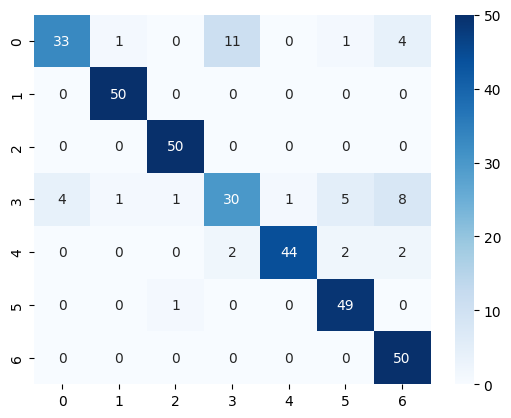

True: 2, Pred: 2


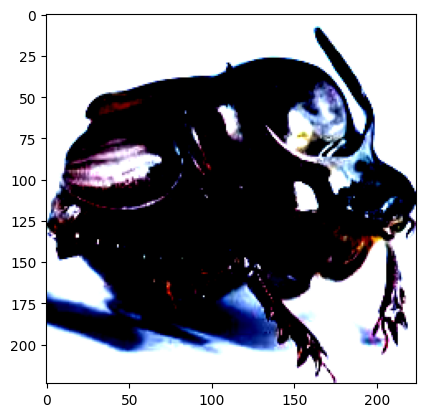

True: 5, Pred: 5


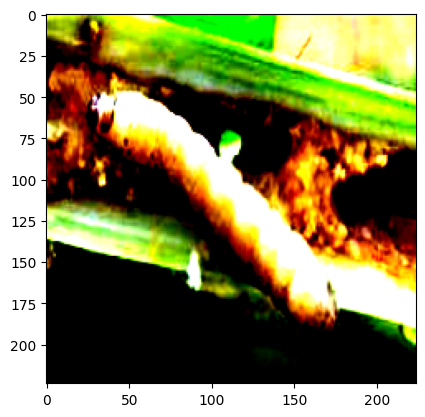

True: 2, Pred: 2


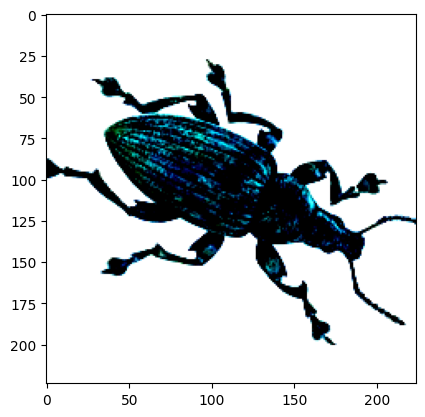

True: 0, Pred: 6


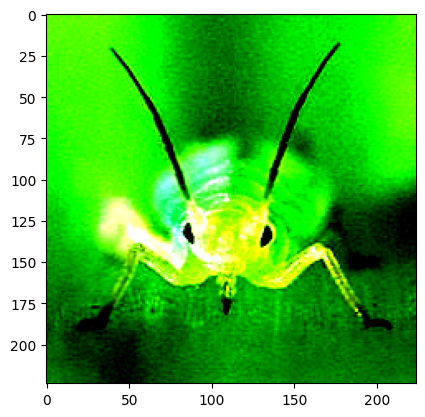

True: 6, Pred: 6


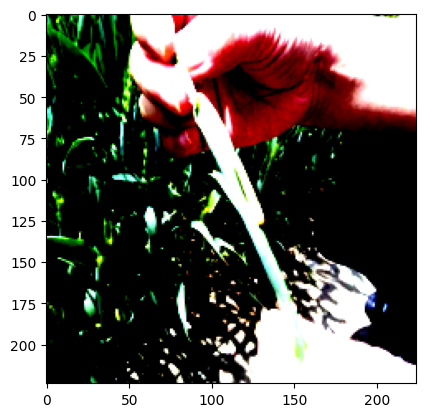

True: 3, Pred: 0


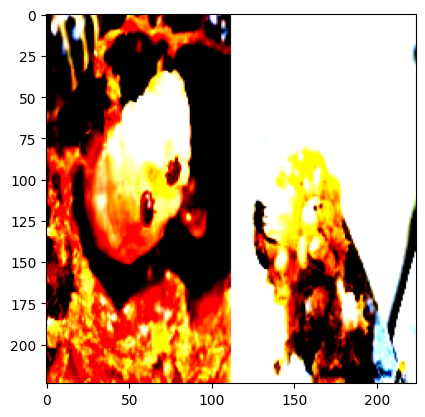

True: 2, Pred: 2


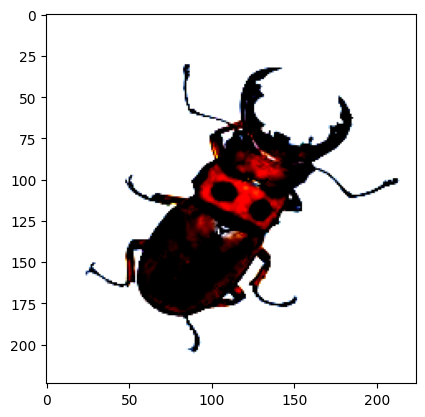

True: 1, Pred: 1


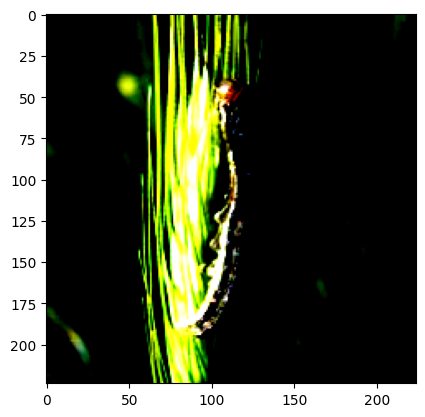

True: 5, Pred: 5


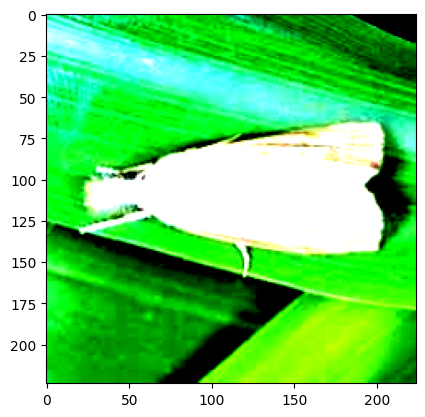

True: 0, Pred: 3


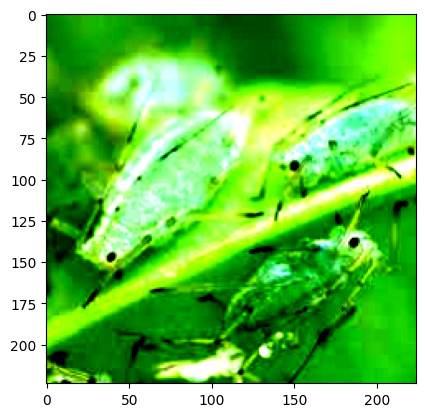

True: 5, Pred: 5


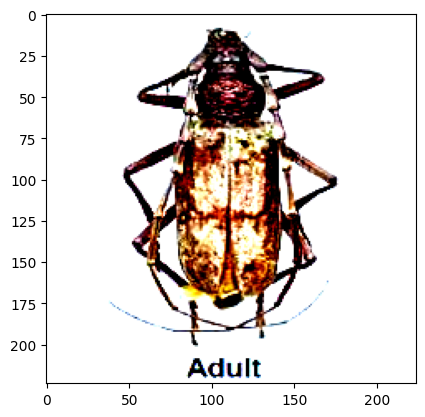

True: 6, Pred: 6


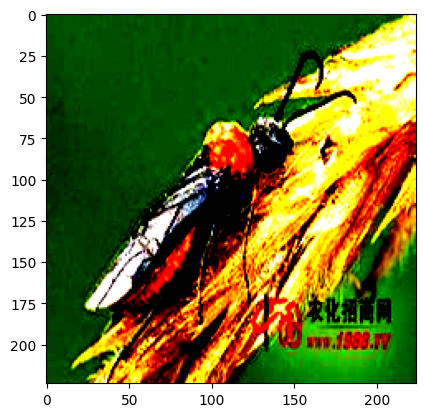

Model saved for 75 epochs


In [ ]:

train_model(model, criterion, optimizer, start_epoch=1, num_epochs=75)




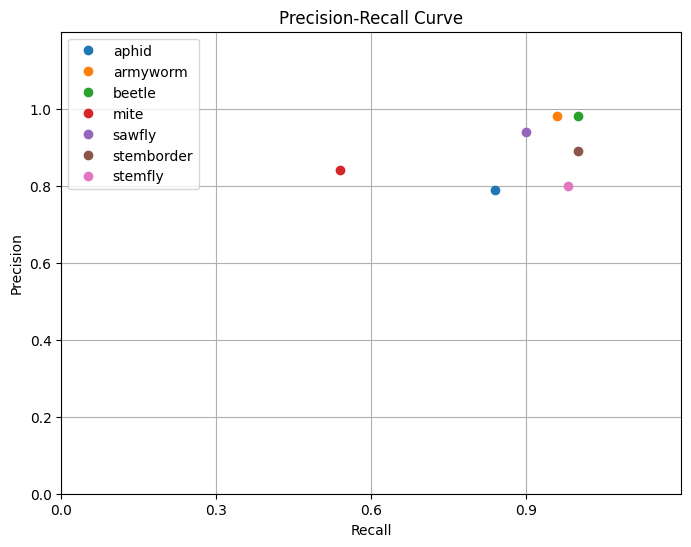

In [2]:
# precision recall curve for 50 epochs
import matplotlib.pyplot as plt
import numpy as np
# Precision and Recall values for each class
classes = ["aphid", "armyworm", "beetle", "mite", "sawfly", "stemborder", "stemfly"]

precision = [0.79, 0.98, 0.98, 0.84, 0.94, 0.89, 0.80]
recall = [0.84, 0.96, 1.00, 0.54, 0.90, 1.00, 0.98]

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))

for i, class_name in enumerate(classes):
    plt.plot(recall[i], precision[i], 'o', label=f"{class_name}")

# **Setting Custom Tick Intervals**

plt.xticks(np.arange(0, 1.2, 0.3))  # X-axis tick spacing
plt.yticks(np.arange(0, 1.2, 0.2))  # Y-axis tick spacing

# Formatting the graph
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.xlim([0, 1.2])
plt.ylim([0, 1.2])
plt.grid(True)
plt.legend()
plt.show()

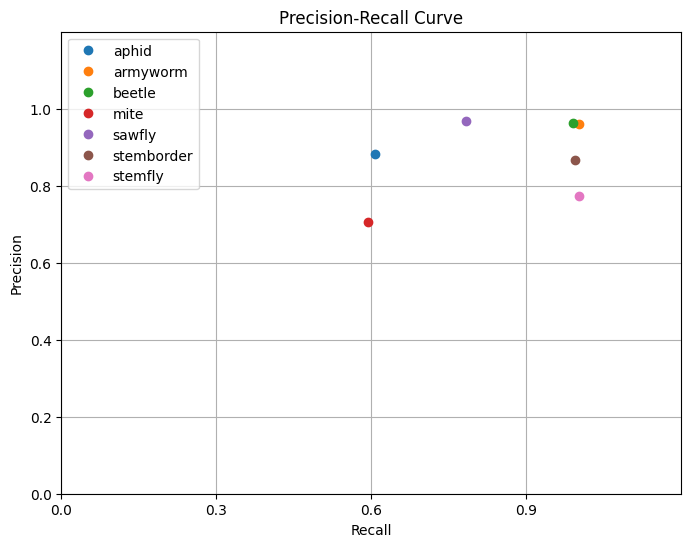

In [6]:
# precision-recall curve for 75 epochs
import matplotlib.pyplot as plt
import numpy as np

# Precision and Recall values for each class
classes = ["aphid", "armyworm", "beetle", "mite", "sawfly", "stemborder", "stemfly"]

precision = [0.89, 0.96, 0.96, 0.70, 0.98, 0.86, 0.78]
recall = [0.60, 1.00, 1.00, 0.60, 0.80, 0.98, 1.00 ]

jitter_strength = 0.02  # Adjust this to spread out overlapping points
recall_jittered = [r + np.random.uniform(-jitter_strength, jitter_strength) for r in recall]
precision_jittered = [p + np.random.uniform(-jitter_strength, jitter_strength) for p in precision]

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))

for i, class_name in enumerate(classes):
    plt.plot(recall_jittered[i], precision_jittered[i], 'o', label=f"{class_name}")

# **Set Custom Tick Intervals**

plt.xticks(np.arange(0, 1.2, 0.3))  # X-axis tick spacing
plt.yticks(np.arange(0, 1.2, 0.2))  # Y-axis tick spacing

# Formatting the graph
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.xlim([0, 1.2])
plt.ylim([0, 1.2])
plt.grid(True)
plt.legend()
plt.show()